As the parent of a toddler, you deal with a multitude of potential problems on an ongoing basis. I personally find myself constantly worrying about whether or not my daughter's getting too much screen time; or if we're reading enough together; and when we are reading, if we're reading the right kinds of books; and also if I'm just spending the highest quality time with her. And, don't even get me started on mealtime...

The point is, as a parent, you have any number of things in the short term to entirely occupy your time, and if that's not enough, you also have your child's future to worry about as well. Fortunately, if you have an interest in using data to predict the future, then that last one is actually quite a bit of fun! 

In this article, I'll go over the analysis that I performed when it came time to really start saving for my child's college education. In fact, this article is basically just a cleaned up version of what I presented to my wife (lucky woman)!

## Defining the Problem

Before we dive into the details, it's a good idea to quickly summarize what it is that we are attempting to do. Essentially, there's really only two steps to this analysis: (1) predicting the cost of college, and (2) calculating the periodic deposits that need to be made in order to meet those future costs. The latter bit is pretty standard stuff, really nothing more than an application of the compounding interest forumula. The interesting bit of this article then is in the prediction step, and that's what I'll concentrate on for the majority of this post.

## The Setup

Let's start by taking a look at what libraries we'll need for our analysis. 

For the most part, it's the typical gang that you might expect: numpy, matplotlib, pandas, seaborn, and scipy.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import gmean

In addtion to the normal python scientific stack, I'm also using the [pandas-datareader][pandas_datareader] package to load S&P 500 values that I'll use to estimate the rate of return I hope to earn on my savings. I'm calling this one out because (as of this writing) there is a clash between the library and the current version of pandas that has been resolved, but hasn't yet been released. So, if you're trying to run this article on your own machine, it's possible that the latest version of datareader has been released already, but if you happen to run into issues, try installing the package with the line below.

```
pip install -U git+https://github.com/pydata/pandas-datareader.git
```

[pandas_datareader]: http://pandas-datareader.readthedocs.io/en/latest/

In [2]:
# I had a ton of trouble with the pandas-datareader library. Basically, the 
# latest version of pandas broke it and the fix is not in a released version 
# as of 2018-06-27. So, I hand to install the dev version to get things to 
# work (pip install git+https://github.com/pydata/pandas-datareader.git).
import pandas_datareader as pdr

**NOTE:** The code cell below (in addition to this explanatory text) does not show up in the article because it does not provide any value in understanding the topic. The code below exists only to hide some of the warnings that are emitted when running the cross validation below in an attempt to keep the output of this notebook clean. 

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Constants

To make things a bit more readable, we'll create a handful of constants that we can use throughout our analysis. Below I create constants to hold the year my daughter will begin college, and consequently the number of years I have left to save for that day. In addition, I create a constant for holding the number of pay periods in a year, and the return on investment that I expect to earn on my savings. 

For the last value, the expected return on my investments, I will use the datareader library to pull in a starting and ending S&P 500 value that I then use to calculate the Expected ROI. I'm using a window of time between the starting and ending value equal to the amount of time I have before my daughter starts college, and I basically just take the geometric mean of the two numbers to get the average annual rate of return.

In [4]:
# The year my daughter will (most likely) start college
YEAR_ENTERING_COLLEGE = 2033
# The number of years I have left to save for the big day
YEARS_TO_SAVE = YEAR_ENTERING_COLLEGE - datetime.now().year
# There are 26 bi-weekly pay periods per year
NUM_PAY_PERIODS_PER_YEAR = 26

# Calculate the expected ROI of any investments we make for Ellie's college
# based on the average rate of return of the S&P 500. I'm using a window
# equal to the number of years until Ellie goes to college for the average
# return calculation. https://yhoo.it/2N9sdC6
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=YEARS_TO_SAVE)
sp = pdr.get_data_yahoo('^GSPC', start_date, end_date, interval='m')
EXPECTED_ROI = (sp.iloc[-1].Close/sp.iloc[0].Close)**(1/YEARS_TO_SAVE) - 1

Since I live in the heart of Silicon Valley, my current plan (hope) is that my daughter will stay close to home and either attend Stanford or Berkeley. Since Stanford is the more expensive of the two, I decided to focus my attention on saving for that scenario, and if she decides to go to Berkeley instead, the leftover cash will just into our retirement account. 

With that in mind, I pulled historical Stanford tuition data from the [Chronicle of Higher Education][1] and checked it against the data I found on the [Stanford website][2] and it appears to be quite accurate. I saved the tuition information into a file named 'stanford.csv' and I load the data in the cell below. 

> For anyone wanting to perform their own analyiss, it should be relatively easy to do so by simply grabbing the data for another school, saving it to a new file, changing the file name below and rerunning the code in this document.

**UPDATE (2018-06-29):** After a bit of searching I found a website for a [Data Journalism class][3] taught at Stanford that had a screenshot of [Stanford's historical tuition schedule][4]. This helped me fill in the rest of the data from the 90's and has helped me make the models even more accurate.

[1]: https://www.chronicle.com/interactives/tuition-and-fees
[2]: http://facts.stanford.edu/academics/undergraduate-facts
[3]: http://2017.padjo.org/index.html
[4]: http://2017.padjo.org/assignments/can-viz/stanford-tuition-history.html#stanford-tuition-historical-table

In [5]:
# historical_amts = pd.read_csv('./stanford.csv')
# historical_amts['year'] = pd.to_datetime(historical_amts['year'])
# historical_amts.set_index('year', inplace=True)
# Can also do it all in one line, like so...
historical_amts = pd.read_csv('stanford.csv', index_col='year', parse_dates=['year'])

In [6]:
#historical_amts = historical_amts['2000':]

# before_recession = historical_amts['2000':'2005']
# after_recession = historical_amts['2010':]
# historical_amts = before_recession.append(after_recession)

#historical_amts = historical_amts['1990':'1999']
#historical_amts = historical_amts['2000':'2009']
#historical_amts = historical_amts['2010':]
#historical_amts = historical_amts['1990':]

# offset = str(pd.Timestamp.now().year - YEARS_TO_SAVE)
# historical_amts = historical_amts.truncate(before=offset)

## Geometric Mean

Ok, with all of the preliminaries out of the way, we're ready to get down to the business of prediction. 

In general, the simpler the model, the better. The beauty of a simple model is that they are easy to understand and explain, and so if a simple model can give you what you need, you're best of going with that---even at the expense of some predictive power. It's a good idea then to start with simplest possible approach that we can think of, and that's to simply find the average rate of increase, and then compound that over that next several years. 

In this first section, we're going to start with the simplest possible model. I'm going to calculate the average rate of increase and use that to predict the future cost of college when my daughter is ready to attend. We find the average rate of increase by taking the [geometric mean][geometric_mean] of the yearly rate hikes over the past {{historical_amts.index[-1].year - historical_amts.index[0].year}} years, which is what the `calc_avg_tuition_increase` function does below. 

[geometric_mean]: https://en.wikipedia.org/wiki/Geometric_mean

In [7]:
# Get the percentage increase in all but the first year
# and add a 1 to each rate so we can find the geometric 
# mean. 
# yearly_rate_hikes = historical_amts['tuition'].pct_change()[1:]
# avg_tuition_increase = gmean(yearly_rate_hikes + 1) - 1

def calc_avg_tuition_increase(data):
    """Calculates the average tuition increase based on the given dataset
    """
    num_years_past = data.index[-1].year - data.index[0].year
    total_tuition_increase = data.iloc[-1]['tuition']/data.iloc[0]['tuition']
    avg_tuition_increase = total_tuition_increase**(1/num_years_past) - 1
    return avg_tuition_increase

avg_tuition_increase = round(calc_avg_tuition_increase(historical_amts) * 100, 2)
print('{:.2f}%'.format(avg_tuition_increase))

4.72%


Looks like Stanford's tuition goes up, on average, by around {{avg_tuition_increase}}% each year. That's a pretty hefty increase, so we'll probably need to be fairly aggressive with our investments. We want to make sure that we are getting a return above {{int(np.ceil(avg_tuition_increase))}}%, so the investment of a sizeable portion of our funds into the stock market is pretty much a foregone conclusion. 

Before we move on, however, let's just make sure that our math is correct. In the next bit of code we're going to run the principal amount (the tuition at the start of the dataset) through the compounding interest formula with the average rate we just calculated.

$$
\text{Future Value} = \text{Principal} \times \bigg(1 + \frac{r}{n} \bigg)^{nt}
$$

The formula above is what we've implemented below in the `compound` function, where $r$ is the interest rate (or, the rate of return we calculated above), $n$ is the number of compounding periods in a year, and $t$ is the number of years for our investment to compound.

In [8]:
def compound(principal, rate, years, periods=1):
    """Calculates the FV of a principal amount years into the future
    
    Arguments:
    principal -- the initial amount in the FV calculation
    rate -- the annual interest rate
    years -- number of years into the future to project the FV
    
    Keyword Arguments:
    periods -- number of compounding periods per year
    
    """
    return principal * (1.0 + rate/periods)**(years * periods)

To keep our code clean and reusable, we're going to create a function to create each type of model. We'll try to stick with the same pattern as much as is feasible, but the general gist is that we simply call the function, pass in some training data, and out pops a model. The model that's returned should be a callable that, when called with a year, will return an estimate of that year's expected tuition. Our first function below doesn't really do any "training" in the traditional sense, but to keep things consistent, we'll still think of it as training a model, and name the function accordingly.

Our `train_compounding_model` function below actually creates a class, and returns an instance of it, that is callable rather than a simple function. The reason we do this is just to make it easy to also return some related information that we may be interested in, like the average rate of increase, for example.

In [9]:
def train_compounding_model(train):
    """Creates a compounding model based on average tuition increase
    
    This model uses the geometric mean of the given training dataset to 
    create a model that calculates the future value of tuition by 
    compounding a given principal amount.
    
    Arguments:
    train -- time series of tuition costs per year

    """
    class CompoundingModel(object):
        def __init__(self):
            self.avg_tuition_increase = calc_avg_tuition_increase(train)
            self.principal = train.iloc[0]['tuition']
            self.data = train
            
        def __call__(self, year):
            offset = year - self.data.index.year[0]
            return compound(self.principal, self.avg_tuition_increase, offset)
        
    return CompoundingModel()
     

Now that we have a training function for our compounding model, we can use it to create an instance of this model using the historical tuition data and then check our math by making sure that the model correctly predicts the tuition for the most current year ({{historical_amts.index[-1].year}}) in our dataset.

In [10]:
# Train our model
cm = train_compounding_model(historical_amts)

# Then check its accuracy by calcuating the tuition for the most
# recent year in our dataset.
expected_amt = historical_amts.iloc[-1]['tuition']
calculated_amt = int(round(cm(historical_amts.index[-1].year)))
print('Expected Amount  : ${:,}\nCalculated Amount: ${:,}'.format(
    expected_amt, calculated_amt))

Expected Amount  : $49,617
Calculated Amount: $49,617


Perfect! The final calculated amount is exactly the same as the actual amount in {{historical_amts.index[-1].year}}, so the math is sound. 

Given that the rate is correct, and assuming that the average rate of increase stays roughly the same over the next few years, we should be able to extrapolate out the cost of tuition for Stanford when my daughter is ready to run off to college.

In [11]:
print('First year cost: ${:,}'.format(int(cm(YEAR_ENTERING_COLLEGE))))

First year cost: $103,792


Phew, that is painful! The yearly cost of tuition for Stanford in {{YEARS_TO_SAVE}} years will be roughly {{int(cm(YEAR_ENTERING_COLLEGE)/1000)}}k, according to our model. That's good information to have at our disposal, but what we really need is the total cost of our daughter's education. To determine that, we will need predictions for each year that our daughter is expected to be in college. In the interest of keeping things reusable, we'll again create a function that can be reused with several different models. The `predict` function below takes a model object, a start year, and either an end year or the number of years that we want to predict.

In [12]:
def predict(model, start=None, end=None, years=0):
    """Returns a dataframe containing predictions for the given date range
    
    This function really only exists to turn the array of predicted values 
    into a time series, i.e., a dataframe with a pandas DatetimeIndex. 
    
    Arguments:
    model -- the model being used to make predictions
    start -- the year of the start of the date range
    end -- the year of the end of the date range (inclusive)  
    years -- the number of years to predict (if end is None)
    
    """
    if start is None:
        start = pd.Timestamp.now().year
    if end is None:
        end = start + years -1
        
    dates = pd.date_range(str(start), str(end), freq='YS')
    df = pd.DataFrame({
        'tuition': model(dates.year).astype(int)
    }, index=dates).rename_axis('year')
    return df 

Now, we can use our function to calculate the full cost of our daughter's education using our compounding model. In other words, we will be calculating the total cost of college under the assumption that the cost will continue to go up by about {{avg_tuition_increase}}% each year, and that our daughter goes to college for 4 years in total. Under those assumptions we're looking at a grand total of...

In [13]:
expected_tuition = predict(cm, YEAR_ENTERING_COLLEGE, years=4)
total_cost_of_education_cm = expected_tuition.tuition.sum()
print('Total cost of education: ${:,}'.format(total_cost_of_education_cm))

Total cost of education: $445,504


Ok, so now that we know the full extent of the damage, we need to calculate how much we'll need to save on a regular basis in order to be able to put our little girl through Stanford. Doing a little bit of algebraic manipulation of the compounding interest formula gives us the following equation for finding the periodic deposits that we'll need to make over the coming years.

$$
\text{Deposit Amount} = \frac{
    \text{Future Value}
}{
    \sum_{i=0}^{n} (1.0 + \text{rate of return})^{i}
}
$$

Where $n$ is the number of compounding periods, i.e., the number of years we have to save up multiplied by the number of times per year that we will make a deposit into our college account, and Future Value is the total cost of college. The `calc_deposit_amount` function below uses the formula above to calculate the amount that we will need to deposit on a regular basis to meet our savings needs.

In [14]:
def calc_deposit_amount(total_cost, years, periods, rate=0.03, principal=0):
    """Returns the amount of each payment
    
    Arguments:
    total_cost -- total cost of tuition for all 4 years
    years -- number of years until withdrawal begins
    periods -- number of compounding periods per year
    principal -- initial amount invested
    rate -- the average rate of return on investments
    
    """
    # First, calculate the FV of the principal amount and subtract it
    # from the total cost, so we are only determining how much more we
    # will need to invest.
    total_cost -= principal * (1 + rate)**years
    return int(total_cost/(sum((1.0 + rate/periods)**i for i in range(periods*years))))

And, the next bit of code calculates the deposit amount based on the number of years we still have to save, the number of deposits per year we'll make (in our case, that will be the number of pay periods per year), and the expected rate of return we should make on our investments. In addition, I've included another optional field for including a starting principal amount, which is our case is about $10,000.

In [15]:
deposit_amt = calc_deposit_amount(total_cost_of_education_cm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  10000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

Bi-weekly deposit amount: $588


Well \${{deposit_amt}} every other week doesn't necessarily feel completely out of the question, but it does feel quite high to me. So, before I set up the automatic withdrawal on my bank account to take every last bit of disposal income I have, it's probably a good idea to probe a bit deeper, and the first place we're going to start is with a visualization. 

<!-- I figured I would take a look at the data and see if perhaps extrapolating out the possible cost through the use of the geometric mean is a bit too aggressive. To do that, I want to first get a look at the historical amounts coupled with the predicted amounts over the next several years to see if the data looks good. -->

To do that, we'll need another function that stiches together two `DataFrame` objects into a single visualization. Then, we can use the function to visualize both the historical tuition data and our predicted tuition costs to see just how well our predictions fit the natural shape of the tuition progression.

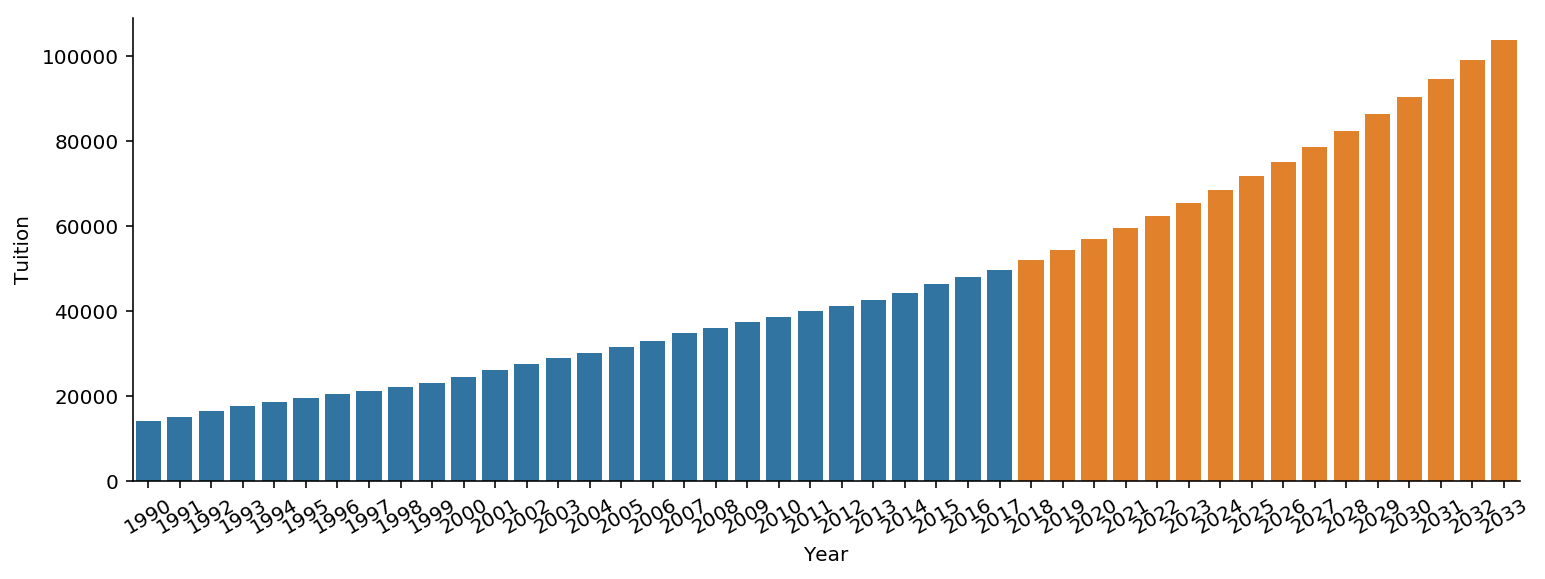

In [16]:
def plot_predictions(historical_data, predicted_data):
    """Plots historical and predicted amounts on a single graph
    
    Arguments:
    historical_data -- historical tuition data
    predicted_data -- predicted tuition data
    
    """
    # First, stich the two data frames together into one
    historical_data = historical_data.copy(deep=True)
    predicted_data = predicted_data.copy(deep=True)
    historical_data['predicted'] = False
    predicted_data['predicted'] = True
    df = historical_data.append(predicted_data).drop_duplicates()
    
    # Then, plot the resultant dataset
    g = sns.factorplot(data=df.reset_index(), x='year', y='tuition', 
                       kind='bar', 
                       hue='predicted',
                       dodge=False,
                       aspect=3,
                       legend=False)
    g.set_xticklabels(df.index.year.values, rotation=30) 
    g.set_xlabels('Year')
    g.set_ylabels('Tuition')

# Now, let's make our predictions and visualize the full data set
first_year_to_predict = historical_amts.index[-1].year + 1
predicted_amts = predict(cm, first_year_to_predict, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

Our visualization shows the historical data in blue, and our predicted tuition in orange. On the whole, it doesn't look bad at all. The transition from past to present (2017 to 2018) looks pretty good, and the progression overall is pretty smooth. It doesn't seem completely out of the realm of possibility, but its growth does appear to accellerate a bit faster than I would've expected just by looking at the historical data. In fact, if we block out the predicted amounts and just concentrate on the historical data, it appears that the annual amounts follow a somewhat linear progression, as is evidenced by the simple scatter plot of the historical data below.

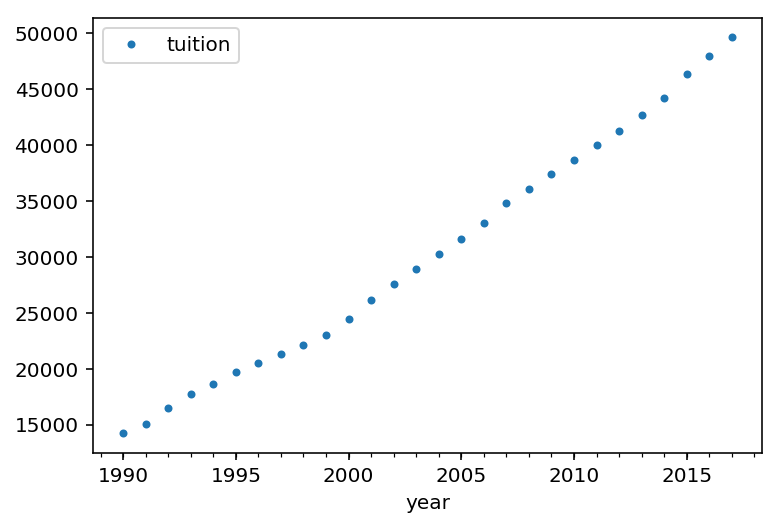

In [17]:
historical_amts.plot(style='.');

Yep, the data looks fairly linear, so maybe a simple linear regression model would be better for estimating the future cost of our daughter's education. It would be nice to have a function that would visualize how well our model fits the data that we have. Then, we could use that function to compare our current model against a linear regression to see which one does a better job of fitting the historical data.

So, let's make that function now. The next cell creates a function called `plot_fit` that takes a `DataFrame` object and a model and plots the predicted amounts from the model against the given dataset so we can get a good picture of how well the model fits the data.

In [311]:
def plot_fit(historical_data, model):
    """Plot the model against the historical data to visualize the fit
    """
    X = historical_data.index.values
    y = historical_data.tuition.values
    y_hat = model(historical_data.index.year)
    plt.plot(X, y, 'b.', X, y_hat, 'r-');

To see how it works, let's use it now with our compounding model to see just how well it fits the historical progression of the tuition rates.

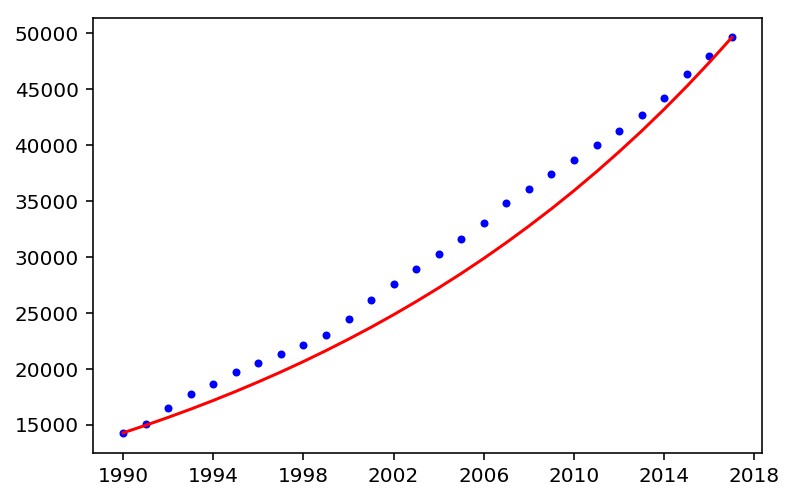

In [19]:
plot_fit(historical_amts, cm)

Hmm, well, it is as I expected, which is to say that the fit isn't quite perfect and the curve looks a bit aggressive when compared to the historical data. Looking at that latest visualization, I feel justified in searching for another model that might better fit our data, and given that the data does look somewhat linear, I think it's worth trying a simple linear regression to see how it performs.

## Linear Model

Just like we did with our last model, we'll again create a function for "training" our model that takes a training dataset and returns a model that can be called with a year to get the predicted tuition for that year.

In [20]:
def train_linear_model(train):
    """Trains a linear regression model with the training data

    Arguments:
    train -- time series of tuition costs per year

    """
    lm = np.poly1d(np.polyfit(train.index.year, 
                              train['tuition'], 1))
    return lm

Now, we can use our function to train a linear regression model and then see how well it fits the data.

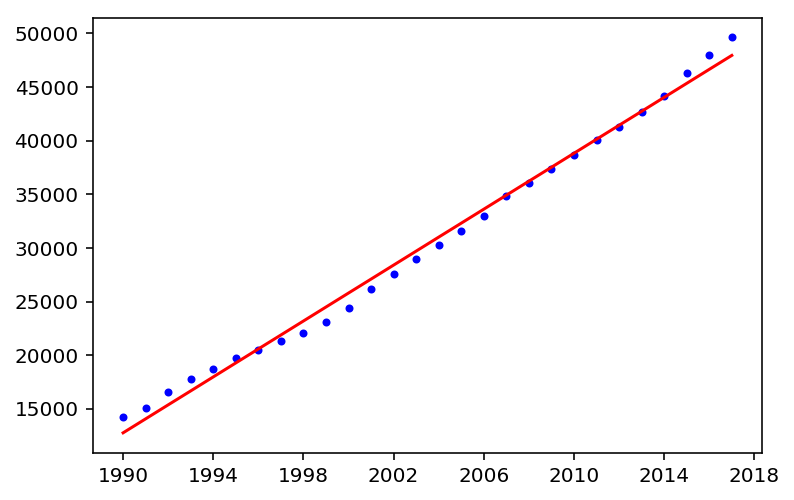

In [21]:
lm = train_linear_model(historical_amts)
plot_fit(historical_amts, lm)

Well, that's not too bad. Overall, the model has a relatively tight fit on the data even given the biased nature of a linear regression, so it should do a decent job with its predictions. To get a better idea of how well a linear regression models our data, let's take a look at the correlation coefficient, then we'll see what it predicts for the cost of tuition when my baby girl starts college.

In [22]:
import statsmodels.api as sm
train = sm.add_constant(historical_amts, 1)
train['year'] = train.index.year
corr_coef = train.year.corr(train.tuition)
corr_coef

0.9965970321885907

A correlation coefficient of {{round(corr_coef,3)}} is pretty high. Honestly, it really doesn't get any higher than that, so it does appear that our model follows a farily linear progression---at least it does in this small window of data that we have here. 

Ok, so our model fits the historical data really well, but what does it predict for Stanford's tuition going forward?

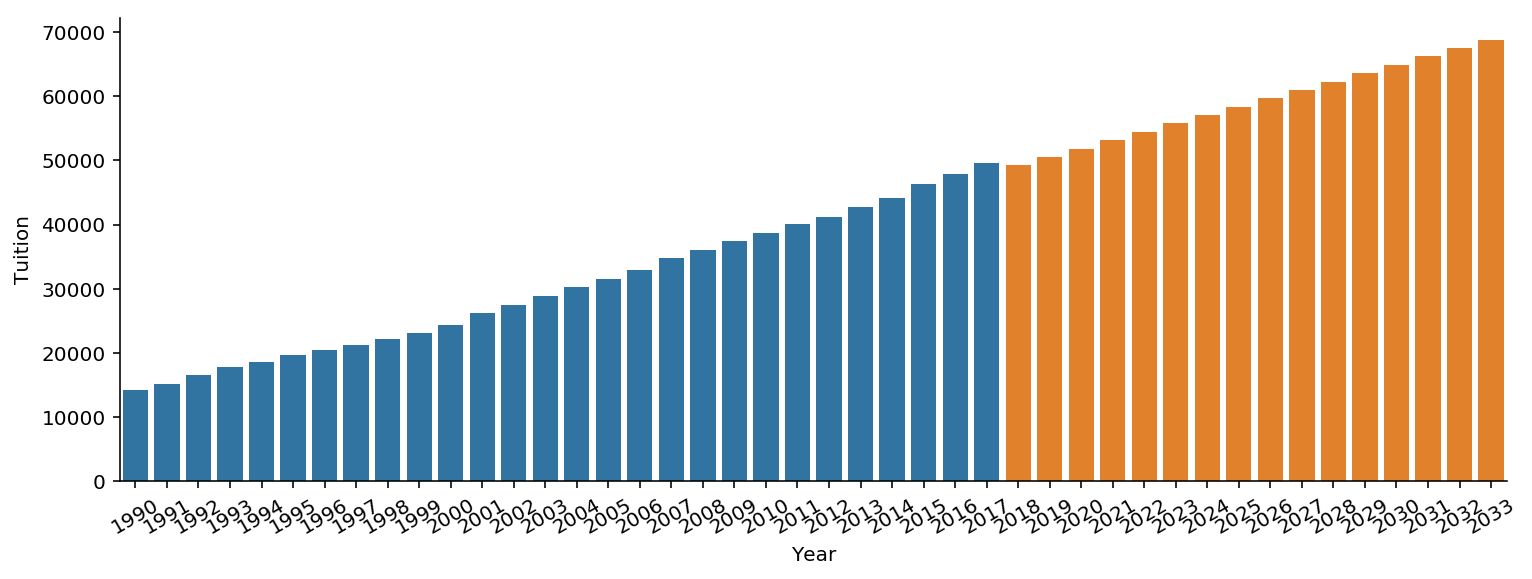

In [23]:
predicted_amts = predict(lm, historical_amts.index[-1].year + 1, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

That's not bad, the progression looks, more or less, like I would expect based on the historical data, but there's a slight dip between the historical and predicted amounts, which I'm pretty sure is going to prove innacurate, so this model may be a little off as well. The other thing that worries me is just how far off its estimate of total cost of college is when compared to a [similar analysis performed by CNBC][cnbc] this past May. The CNBC article is predicting a total cost of $475k for 4 years at Stanford starting in 2036, which is just {{2036 - YEAR_ENTERING_COLLEGE}} years later than my target year. If we adjust our prediction to target the same time period as the CNBC analysis, using the linear model we created in the steps above, our estimate misses theirs by \${{'{:,d}'.format(int(475000 - predict(lm, 2036, years=4).sum()))}}! 

Now, that's quite a significant difference. While, on the whole, I like the fit I'm seeing above, that gigantic difference between our prediction and CNBC's, coupled with the highly unlikely decrease in tuition in the graph above, is making me really suspicious of the linear model. Given these concerns, I think it behooves us to continue on with our investigation to see if we can't find a slightly better predictor.

In the next section, I'll look into fitting higher degree polynomial curves against the data to see if we can do even better, but just to be completely transparent, let's first see what the linear model predicts for the cost of tuition for my little girl over the four years that she'll be at Stanford.

[cnbc]: https://www.cnbc.com/2018/05/17/attending-harvard-will-cost-475000-in-2036-heres-how-much-other-schools-will-charge.html

In [24]:
expected_tuition = predict(lm, YEAR_ENTERING_COLLEGE, years=4)
print('First year cost: ${:,}'.format(expected_tuition.tuition[0]))
total_cost_of_education_lm = expected_tuition.tuition.sum()
print('Total cost of education: ${:,}'.format(total_cost_of_education_lm))
deposit_amt = calc_deposit_amount(total_cost_of_education_lm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

First year cost: $68,797
Total cost of education: $283,006
Bi-weekly deposit amount: $366


## Polynomial Model

In the first section, we calculated a simple average rate of increase and used that to predict the cost of tuition a few years into the future. The result seemed a bit steep, and the data looked linear in shape, so we threw a simple linear model at the data to see what it could do. That one seemed a bit low, so we decided to keep experimenting. The linear model we created in the last section didn't look bad, it's lack of flexibility seems to have kept it from completely matching the shape of the data since it does appear that there is a slight non-linear upturn in the data as the years progress. To deal with that non-linearity, we've decided to look into a polynomial model to see if it can better capture the trend in the data. 

Since we want to add a bit of curvature to our linear model, and a linear function is just a polynomial of [degree][degree] 1, I think the best place to start is with a polynomial of degree 2, in other words, a [quadratic model][quadratic]. Again, we want to make sure that we have reusable code, so let's take our `train_linear_model` function from above and just make it a bit more generic by making the `degree` of the resultant model a parameter of the function. We'll call this new function `train_polynomial_model`, and we define and use it below to create our quadratic model. 

[degree]: https://en.wikipedia.org/wiki/Degree_of_a_polynomial
[quadratic]: https://en.wikipedia.org/wiki/Quadratic_function

In [338]:
def train_polynomial_model(train, degree=1):
    """Trains a polynomial regression model with the training data

    Arguments:
    train -- time series of tuition costs per year
    degree -- degree of the resultant polynomial

    """
    pm = np.poly1d(np.polyfit(train.index.year, 
                              train['tuition'], degree))
    return pm

qm = train_polynomial_model(historical_amts, degree=2)

Now, let's use our `plot_fit` function again to see how well our new model fits the historical tuition data.

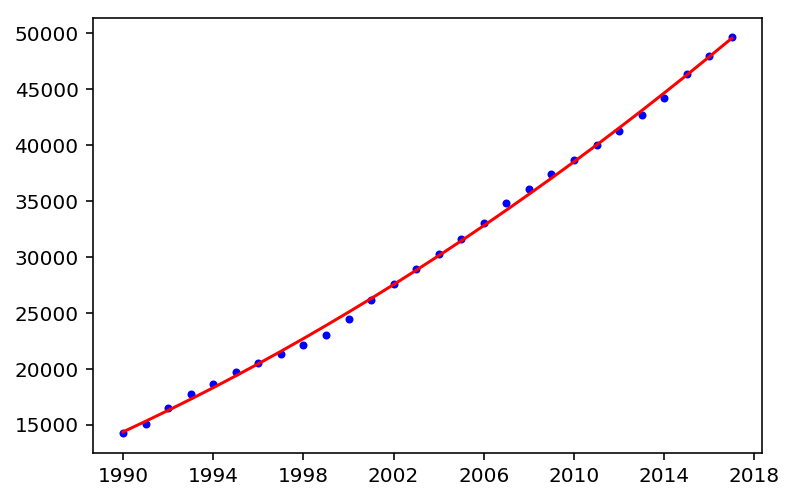

In [312]:
plot_fit(historical_amts, qm)

That's a pretty tight fit! That actually looks better than both of our previous models, but let's see how well it does predicting the future.

First year cost: $79,846
Total cost of education: $332,255
Bi-weekly deposit amount: $436


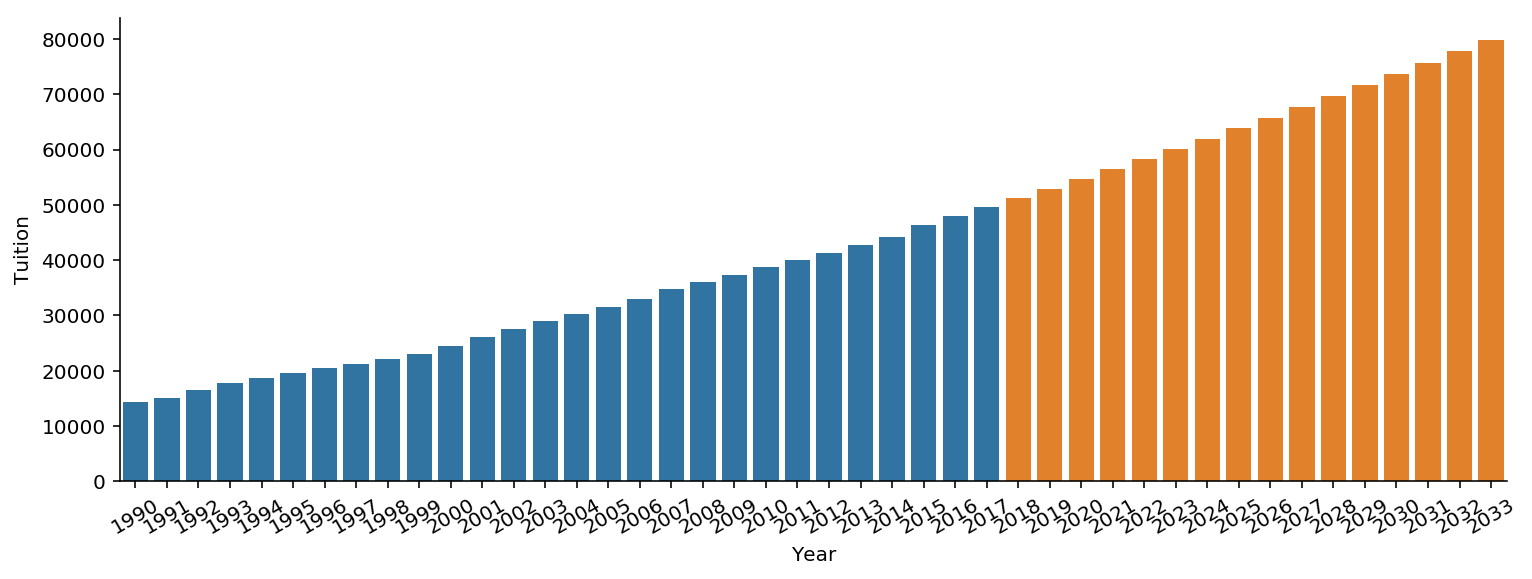

In [316]:
predicted_amts = predict(qm, historical_amts.index[-1].year + 1, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

expected_tuition = predict(qm, YEAR_ENTERING_COLLEGE, years=4)
print('First year cost: ${:,}'.format(expected_tuition.tuition[0]))
total_cost_of_education_qm = expected_tuition.tuition.sum()
print('Total cost of education: ${:,}'.format(total_cost_of_education_qm))
deposit_amt = calc_deposit_amount(total_cost_of_education_qm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

So, now we have what looks like a pretty good model, but it'd be nice if we had a way of saying which is the best that was a bit more rigorous than simply "eyeballing" the data and going with our "gut feeling". Luckily, there are several different measurements that we can use to objectively determine which is the best model for predicting future costs based on the historical data that we have at our disposal. The one that we are going to is called the Root Mean Squared Error, or RMSE for short, and it gives us a measure of how far our predictions are from the actual expected values. The equation isn't particularly difficult to understand, but I'll give a quick explanation of it below. 

$$
RMSE = \sqrt{ \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{f}(x_i))^2 }
$$

Basically, you subtract each predicted value from the actual value, square that, add them all up, and take their average. Then you take the square root of that number to get back to the original units, though this part is totally optional and if it you drop it, you have what is commonly know as the Mean Squared Error (MSE). 

In [331]:
np.mean(cm(X) - y)

-1848.7311583723651

In [317]:
def rmse(predictions, targets):
    """Calculates the Root Mean Squared Error
    """
    return np.sqrt(((predictions - targets)**2).mean())

In [323]:
X = historical_amts.index.year.values.reshape(-1, 1)
y = historical_amts.tuition.values.reshape(-1, 1)
print('Compounding Model RMSE : {}'.format(rmse(cm(X), y)))
print('Linear Model RMSE      : {}'.format(rmse(lm(X), y)))
print('Quadratic Model RMSE   : {}'.format(rmse(qm(X), y)))

Compounding Model RMSE : 2109.185644143689
Linear Model RMSE      : 870.6579896919675
Quadratic Model RMSE   : 344.68012518046623


Judging by the metrics we calculated above, it looks like we have a clear winner: the quadratic model; however, we have two issues that could possibly make this declaration false. First, the data we used to train our models is the exact same data we used to evaluate them. If you picture how a polynomial function works, you can see why this might be bad idea. In essence, as we increase the degree of the polynomial, we add one more bend to our curve. So, a degree 1 polynomial (a line) has no bends, while a degree 2 polynomial (a parabola) has a single bend, and a degree 3 polynomial has 2 bends. In short, a polynomial has $n - 1$ bends in it. What that means is that we can make our curve nearly perfectly fit the data by increasing the number of bends to equal the number of datapoints in our model. In short, the higher the degree of the polynomial, the smaller the RMSE as is demonstrated with the code below.

In [355]:
for degree in range(3, len(historical_amts) + 2):
    pm = train_polynomial_model(historical_amts, degree)
    print('Polynomial ({0:02}) Model RMSE : {1}'.format(degree, rmse(pm(X), y)))

Polynomial (03) Model RMSE : 332.09394394235414
Polynomial (04) Model RMSE : 332.0180576278395
Polynomial (05) Model RMSE : 205.05880546754577
Polynomial (06) Model RMSE : 205.0850212275866
Polynomial (07) Model RMSE : 205.18837514788376
Polynomial (08) Model RMSE : 205.30142919557767
Polynomial (09) Model RMSE : 205.41002364152732
Polynomial (10) Model RMSE : 205.51780366994547
Polynomial (11) Model RMSE : 205.62766990766877
Polynomial (12) Model RMSE : 205.73851853642236
Polynomial (13) Model RMSE : 205.85123446551486
Polynomial (14) Model RMSE : 199.10203829138896
Polynomial (15) Model RMSE : 199.01505141013587
Polynomial (16) Model RMSE : 198.9409050756847
Polynomial (17) Model RMSE : 198.9044786780418
Polynomial (18) Model RMSE : 198.84234232076773
Polynomial (19) Model RMSE : 198.78617183424493
Polynomial (20) Model RMSE : 198.7316616540189
Polynomial (21) Model RMSE : 198.67426422552884
Polynomial (22) Model RMSE : 198.61348005938405
Polynomial (23) Model RMSE : 198.553652846338

And, if we look at the fit our data, we can see that it very nearly fits the data exactly.

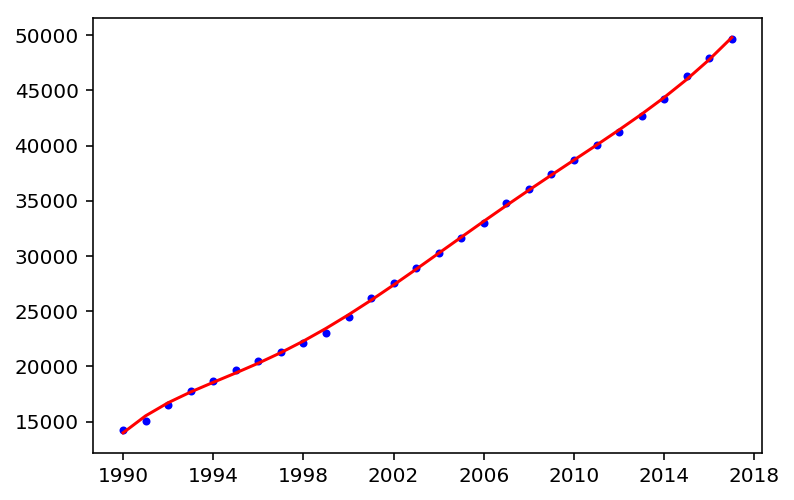

In [356]:
plot_fit(historical_amts, pm)

We can solve this first issue by making sure that we train our model with a different set of data than we use to evaluate it.

The second problem we have is that, in the case of the linear vs. quadratic model, we've essentially tested two different versions of the same type of model. As I mentioned earlier, a linear model is just a polynomial model with a degree of 1. So, in essence, we compared two different types of polynomial models above and the second version seems to have fared better than the first, but how do we know that this is the best polynomial model? In other words, if we think of the degree of our polynomial as a parameter that we can "tune", we can try out several different versions of our model to find the best one. A parameter of this type, one that is not learned from the data, is what we call a hyperparameter, and though it isn't discovered during the learning phase, we do still have automated ways of finding the best possible value for it, and we'll see how to do that in the next few sections.

In [317]:
def train_polynomial_model(data, folds=500):
    """Returns a best fit polynomial model
    
    Performs cross validation to determine the best fit polynomial 
    regression model.
    
    Arguments:
    data -- the training data
    
    Keyword Arguments:
    folds -- the number of folds (i.e., iterations) in the cross validation
    
    """
    # We don't want to overfit the data, so let's keep our polynomial 
    # relativley simple by limiting the degree to no more than half
    # the number of observations in our dataset.
    degrees = len(data)//2
    rmses = [0] * degrees
    for i in range(folds):
        train = data.sample(frac=0.5)
        test = data.drop(train.index)
        for deg in range(1, degrees + 1):
            model = np.poly1d(np.polyfit(train.index.year, train['tuition'], deg))
            predictions = model(test.index.year)
            score = rmse(predictions, test['tuition'])        
            # Calculate the running average of each "fold"
            rmses[deg-1] = (rmses[deg-1] * i + score)/(i + 1)

    # Get the degree for the best (i.e., lowest avg. RMSE) polynomial model
    best_deg_poly = rmses.index(min(rmses)) + 1    
    pm = np.poly1d(np.polyfit(data.index.year, 
                              data['tuition'], 
                              best_deg_poly))

    return pm

pm = train_polynomial_model(historical_amts)

print('Top performing n-degree polynomial: {}'.format(pm.order))

Top performing n-degree polynomial: 2


It appers that a 2nd degree polynomial is the highest performing model in our tests. So, let's create a model based on a quadratic curve fit to our data and see how its predictions look.

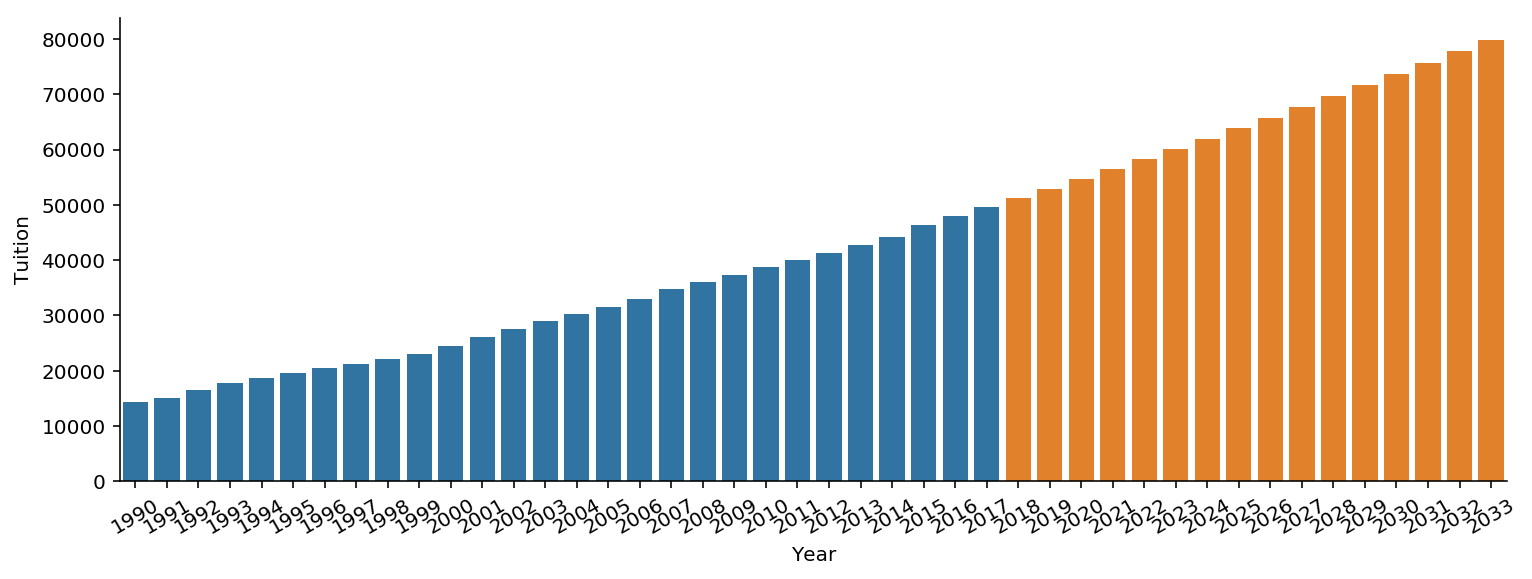

In [26]:
predicted_amts = predict(pm, historical_amts.index[-1].year + 1, YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

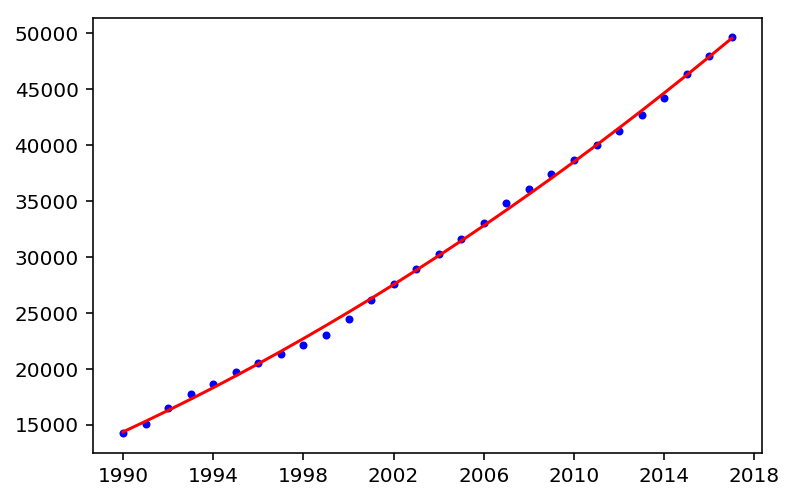

In [27]:
plot_fit(historical_amts, pm)

That's not a gigantic difference compared to the linear model, but it does smooth out that tiny little dip in tuition costs between the historical data and the predicted data, which gives me much more confidence in this model's predictive capabilities. On the whole, this model looks really good, but let's see how they all look together.

In [28]:
expected_tuition = predict(pm, YEAR_ENTERING_COLLEGE, years=4)
total_cost_of_education_pm = expected_tuition.tuition.sum()
print('Total cost of education: ${:,}'.format(total_cost_of_education_pm))
deposit_amt = calc_deposit_amount(total_cost_of_education_pm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

Total cost of education: $332,255
Bi-weekly deposit amount: $436


Total cost of education (Compounding Model): $445,504
Total cost of education (Linear Model)     : $283,006
Total cost of education (Polynomial Model) : $332,255


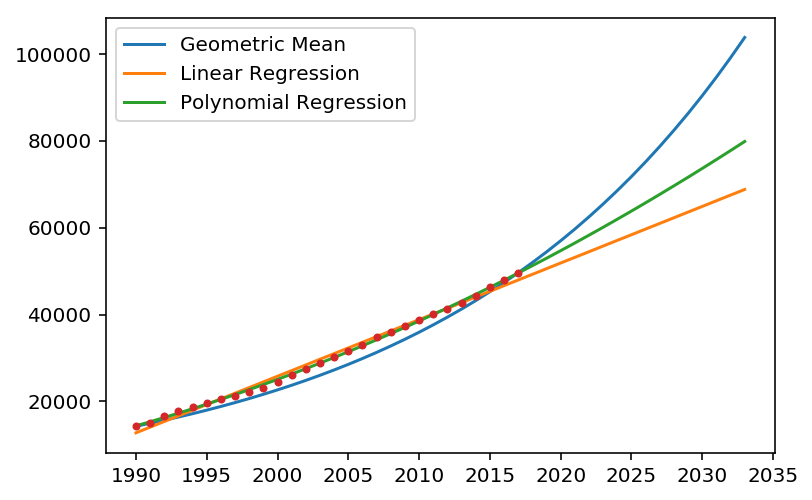

In [29]:
X = pd.date_range(str(historical_amts.index[0].year), 
                  str(YEAR_ENTERING_COLLEGE), freq='YS')
y1 = [int(cm(y)) for y in X.year]
y2 = lm(X.year)
y3 = pm(X.year)
plt.plot(X, y1, label='Geometric Mean')
plt.plot(X, y2, label='Linear Regression')  
plt.plot(X, y3, label='Polynomial Regression')
plt.plot(historical_amts.index.values, historical_amts.tuition.values, '.')
plt.legend()

print('Total cost of education (Compounding Model): ${:,}'.format(total_cost_of_education_cm))
print('Total cost of education (Linear Model)     : ${:,}'.format(total_cost_of_education_lm))
print('Total cost of education (Polynomial Model) : ${:,}'.format(total_cost_of_education_pm))

Yep, that's what I thought, when compared to the two polynomical regressions, the geometric mean model looks too extreme to be accurate---not to mention its curve doesn't fit the known data as well either. I feel confident throwing that model out and instead going with the results from the quadratic curve we fit in the previous cells.

So, with our model now chosen, let's see what the total bill is going to look like.

In [241]:
train = historical_amts[:'2010']
train_x = train.index.year.values.reshape(-1, 1)
train_y = train.tuition.values.reshape(-1, 1)
test_x = historical_amts['2011':].index.year.values.reshape(-1, 1)
test_y = historical_amts['2011':]['tuition'].values.reshape(-1, 1)

In [242]:
_cm = train_compounding_model(train)
rmse(_cm(test_x), test_y)

3246.1984376317296

In [243]:
_lm = train_linear_model(train)
rmse(_lm(test_x), test_y)

2042.7405185280275

In [244]:
_pm_2 = PolynomialRegression(2)
_pm_2.fit(train_x, train_y)
rmse(_pm_2.predict(test_x), test_y)

1253.1763992984709

In [245]:
_pm_3 = PolynomialRegression(3)
_pm_3.fit(train_x, train_y)
rmse(_pm_3.predict(test_x), test_y)

1295.9558025862598

In [246]:
_pm_4 = PolynomialRegression(4)
_pm_4.fit(train_x, train_y)
rmse(_pm_4.predict(test_x), test_y)

1290.2730224572967

In [247]:
_pm_10 = PolynomialRegression(10)
_pm_10.fit(train_x, train_y)
rmse(_pm_10.predict(test_x), test_y)

1253.8970769102255

In [248]:
_pm_20 = PolynomialRegression(20)
_pm_20.fit(train_x, train_y)
rmse(_pm_20.predict(test_x), test_y)

1184.9172794759604

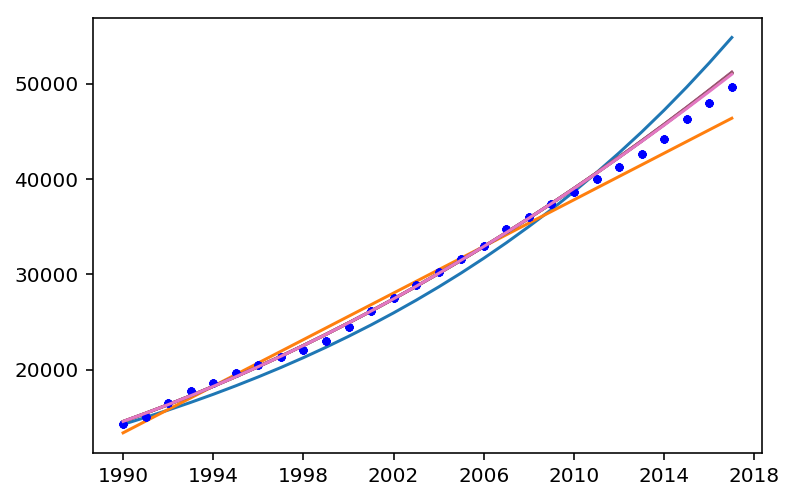

In [253]:
plot_fit(historical_amts, _cm)
plot_fit(historical_amts, _lm)
plot_fit(historical_amts, lambda years: _pm_2.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_3.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_4.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_10.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_20.predict(years.values.reshape(-1, 1)))

In [254]:
train = historical_amts[:'2012']
train_x = train.index.year.values.reshape(-1, 1)
train_y = train.tuition.values.reshape(-1, 1)
test_x = historical_amts['2013':].index.year.values.reshape(-1, 1)
test_y = historical_amts['2013':]['tuition'].values.reshape(-1, 1)

In [255]:
_cm = train_compounding_model(train)
rmse(_cm(test_x), test_y)

1808.838745563537

In [256]:
_lm = train_linear_model(train)
rmse(_lm(test_x), test_y)

1978.9804746182783

In [257]:
_pm_2 = PolynomialRegression(2)
_pm_2.fit(train_x, train_y)
rmse(_pm_2.predict(test_x), test_y)

593.6175343903554

In [258]:
_pm_3 = PolynomialRegression(3)
_pm_3.fit(train_x, train_y)
rmse(_pm_3.predict(test_x), test_y)

579.3316579112785

In [259]:
_pm_4 = PolynomialRegression(4)
_pm_4.fit(train_x, train_y)
rmse(_pm_4.predict(test_x), test_y)

586.5839514850684

In [260]:
_pm_10 = PolynomialRegression(10)
_pm_10.fit(train_x, train_y)
rmse(_pm_10.predict(test_x), test_y)

632.5280037570457

In [261]:
_pm_20 = PolynomialRegression(20)
_pm_20.fit(train_x, train_y)
rmse(_pm_20.predict(test_x), test_y)

718.0840602004747

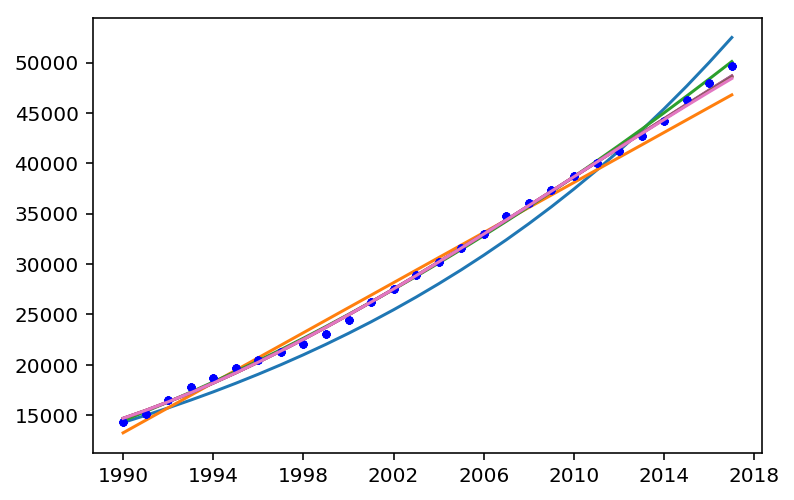

In [262]:
plot_fit(historical_amts, _cm)
plot_fit(historical_amts, _lm)
plot_fit(historical_amts, lambda years: _pm_2.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_3.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_4.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_10.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_20.predict(years.values.reshape(-1, 1)))

In [283]:
train = historical_amts[:'2005']
train_x = train.index.year.values.reshape(-1, 1)
train_y = train.tuition.values.reshape(-1, 1)
test_x = historical_amts['2006':].index.year.values.reshape(-1, 1)
test_y = historical_amts['2006':]['tuition'].values.reshape(-1, 1)

In [264]:
_cm = train_compounding_model(train)
rmse(_cm(test_x), test_y)

5381.228110245521

In [265]:
_lm = train_linear_model(train)
rmse(_lm(test_x), test_y)

3118.652088586067

In [266]:
_pm_2 = PolynomialRegression(2)
_pm_2.fit(train_x, train_y)
rmse(_pm_2.predict(test_x), test_y)

1254.5936645251218

In [267]:
_pm_3 = PolynomialRegression(3)
_pm_3.fit(train_x, train_y)
rmse(_pm_3.predict(test_x), test_y)

10650.442936468768

In [268]:
_pm_4 = PolynomialRegression(4)
_pm_4.fit(train_x, train_y)
rmse(_pm_4.predict(test_x), test_y)

10699.291239074766

In [269]:
_pm_10 = PolynomialRegression(10)
_pm_10.fit(train_x, train_y)
rmse(_pm_10.predict(test_x), test_y)

10988.943589553372

In [270]:
_pm_20 = PolynomialRegression(20)
_pm_20.fit(train_x, train_y)
rmse(_pm_20.predict(test_x), test_y)

11479.80999855399

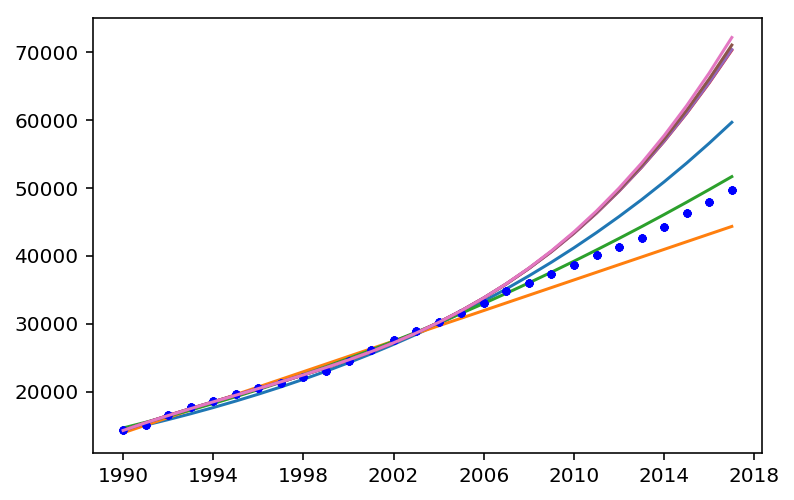

In [274]:
plot_fit(historical_amts, _cm)
plot_fit(historical_amts, _lm)
plot_fit(historical_amts, lambda years: _pm_2.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_3.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_4.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_10.predict(years.values.reshape(-1, 1)))
plot_fit(historical_amts, lambda years: _pm_20.predict(years.values.reshape(-1, 1)))

# Bias-Variance Tradeoff

After playing around with the models and the data a bit, I've noticed that the polynomial regression model, which at one point was my favorite, seems to have significant issues when the training data is changed. Specifically, I am seeing a huge difference in the models generated when the training data is changed, which seems to suggest that the model is overfitting the training data. 

To illustrate this problem, the code below slides a 10-year window across the historical data and uses that slice as the training data for each of the 3 model types. I then plot the total costs that each model calculates based on the given training data.

In [30]:
costs = {
    'compounding': [],
    'linear': [],
    'polynomial': []
}

# The slice is inclusive and we only want 10 years at a time, so 
# I'm adding 9 years to the start of the window instead of 10.
window_offset = 9
start = historical_amts.index[0].year
end = historical_amts.index[-1].year - window_offset
for i in range(start, end):
    window = historical_amts[str(i):str(i + window_offset)]
    _cm = train_compounding_model(window)
    _lm = train_linear_model(window)
    _pm = train_polynomial_model(window, folds=250)
    costs['compounding'].append(calc_cost_of_college(_cm, YEAR_ENTERING_COLLEGE))
    costs['linear'].append(calc_cost_of_college(_lm, YEAR_ENTERING_COLLEGE))
    costs['polynomial'].append(calc_cost_of_college(_pm, YEAR_ENTERING_COLLEGE))    

costs = pd.DataFrame(costs)
costs.plot();

NameError: name 'calc_cost_of_college' is not defined

As you can easily see from the plot above, the training data used has an extreme effect on the output of the polynomial model. Depending on what slice of the data is used for training, the polynomial model predicts anywhere from \$50k to \$3.5M for the total cost of attending Stanford. This is a classic example of overfitting as our model has reduced its bias at the cost of greatly increasing its variance. The model could still be useful, but we'll need to find a way to make it reduce its variance a tad. So, my next step will be to try to dampen the effect of each coefficient on the overall model through L1 or L2 normalization. 

| Coefficient | Value                                      |
|-------------|--------------------------------------------|
| $\beta_0$   | {{ print('{:,.2f}'.format(pm.c[2])) }}     |
| $\beta_1$   | {{ print('{:,.2f}'.format(pm.c[1])) }}     |
| $\beta_2$   | {{ print('{:,.2f}'.format(pm.c[0])) }}     |

## Cross-validation and Regularization: Polynomial Part II

# Cross-validation

Rather than try several different polynomials and eyeballing the fit, it's better to get a bit more formal and use some of the tools that scikit-learn provides. In this section, we'll go over the following topics of interest:

- Creating a polynomial regression with scikit-learn
    - LinearRegression
    - PolynomialRegression
- Pipelines
- Cross-validation w/ Time Series
    - Why use cross-validation?
    - What's so different about using CV w/ time series?
        - [Cross-validation for time series][1]
        - [Time Series Cross-Validation (book exerpt)][2]
        - [Cross Validation of Time Series Data w/ Scikit-Learn ][3]
        - [Time Series Nested Cross-Validation][4]
        
    - [TimeSeriesSplit][5]
- Grid Search
    - [Python Data Science Handbook - Grid Search][6]
    
    
[1]: https://robjhyndman.com/hyndsight/tscv/
[2]: https://otexts.org/fpp2/accuracy.html#time-series-cross-validation
[3]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data
[4]: https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9
[5]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
[6]: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-in-Practice:-Grid-Search

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline

In [32]:
lreg = LinearRegression()

In [281]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [305]:
X = historical_amts.index.year.values.reshape(-1, 1)
y = historical_amts.tuition.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [36]:
scores = cross_val_score(lreg, X, y, cv=TimeSeriesSplit(n_splits=27), scoring='neg_mean_squared_error')
np.mean(scores)

-1007090.0643184121

In [306]:
scores = []
tsp = TimeSeriesSplit(15)
for train, test in tsp.split(X):
    print(train, test)
    lreg.fit(X[train], y[train])
    scores.append((lreg.predict(X[test]) - y[test])**2)
np.mean(scores)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] [25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] [26]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 2

1564299.76718678

In [144]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree, include_bias=False),
                         LinearRegression(**kwargs))

In [75]:
preg = PolynomialRegression(0, fit_intercept=True)
scores = cross_val_score(preg, X, y, cv=TimeSeriesSplit(n_splits=27))
np.mean(scores)

0.0

# Grid Search

We can use grid search to tune the hyperparameters of our model---in this case that would be whether or not to fit the y-intercept (or go through the origin), and the degree of the polynomial.

In [76]:
param_grid = {'polynomialfeatures__degree': np.arange(0,11),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), 
                    param_grid, 
                    cv=TimeSeriesSplit(n_splits=27), 
                    scoring='neg_mean_squared_error')

grid.fit(X, y)

grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}

In [35]:
X = historical_amts.index.year.values.reshape(-1, 1)
y = historical_amts.tuition.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [44]:
lreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

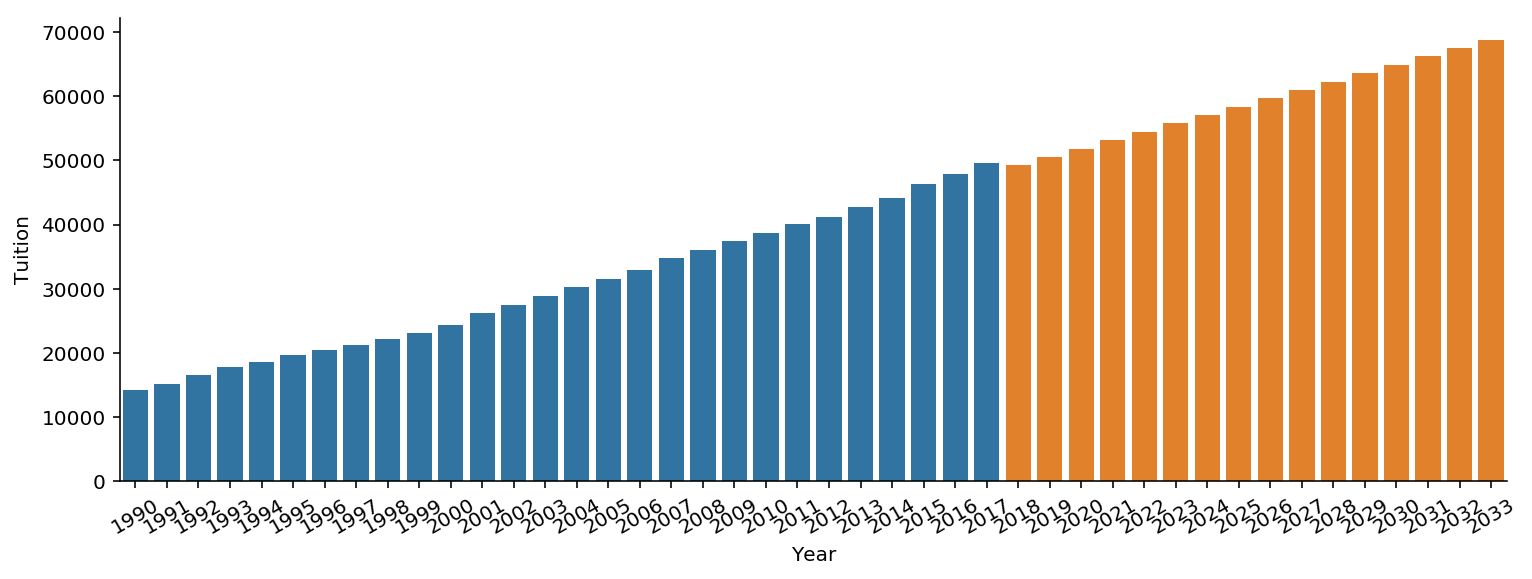

In [45]:
def model(years):
    years = years.values.reshape(-1, 1)
    predictions = lreg.predict(years).reshape(1, -1)[0]
    return predictions

predicted_amts = predict(model, 
                         historical_amts.index[-1].year + 1, 
                         YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

## Polynomial Regression and Regularization 

In [107]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [108]:
alphas = [0.5, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 10000]
pmr = make_pipeline(PolynomialFeatures(3), RidgeCV(alphas))

In [48]:
X = historical_amts.index.year.values.reshape(-1, 1)
y = historical_amts.tuition.values.reshape(-1, 1)
pmr.fit(X, y)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridgecv', RidgeCV(alphas=[0.5, 1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 10000],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))])

In [49]:
pmr.predict(2033)

array([[79380.32099875]])

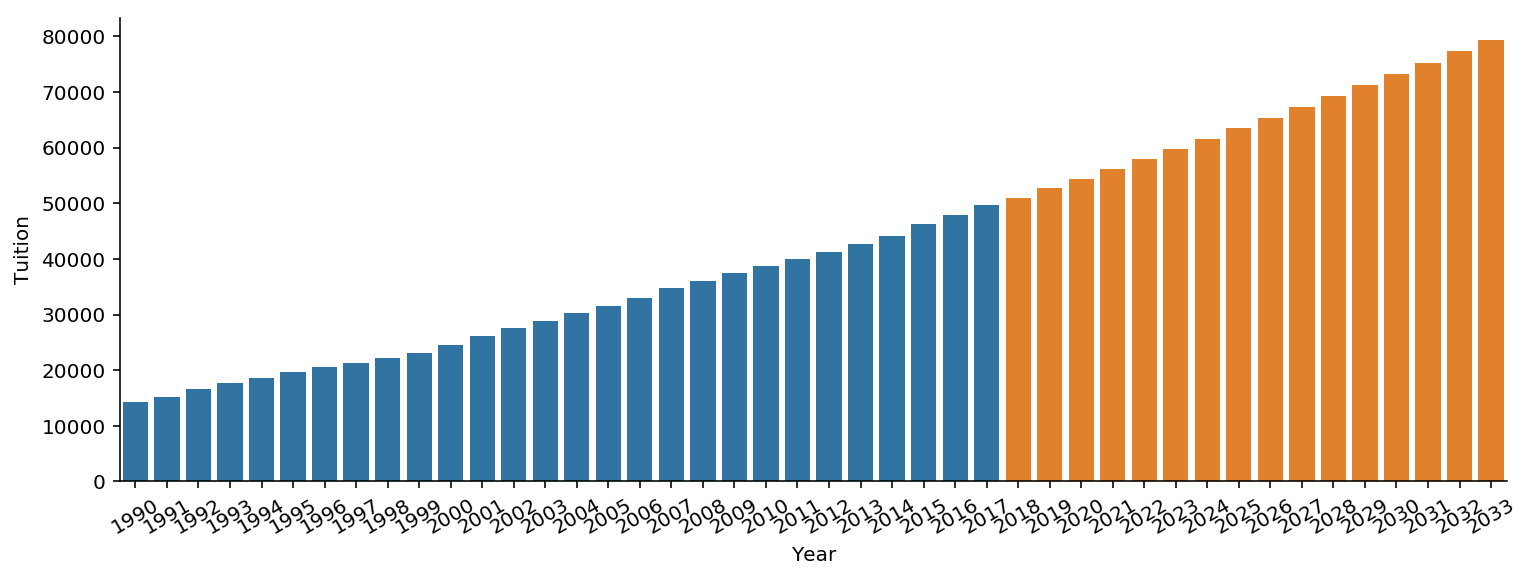

In [50]:
def model(years):
    years = years.values.reshape(-1, 1)
    predictions = pmr.predict(years).reshape(1, -1)[0]
    return predictions

predicted_amts = predict(model, 
                         historical_amts.index[-1].year + 1, 
                         YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

In [51]:
predicted_amt = int(pmr.predict(YEAR_ENTERING_COLLEGE))
print('First year cost: ${:,}'.format(predicted_amt))
total_cost_of_education_pmr = calc_cost_of_college(lambda y: pmr.predict(y), YEAR_ENTERING_COLLEGE)
print('Total cost of education: ${:,}'.format(total_cost_of_education_pmr))

First year cost: $79,380


NameError: name 'calc_cost_of_college' is not defined

Total cost of education (Compounding Model): $445,504
Total cost of education (Linear Model)     : $283,006
Total cost of education (Polynomial Model) : $332,255


NameError: name 'total_cost_of_education_pmr' is not defined

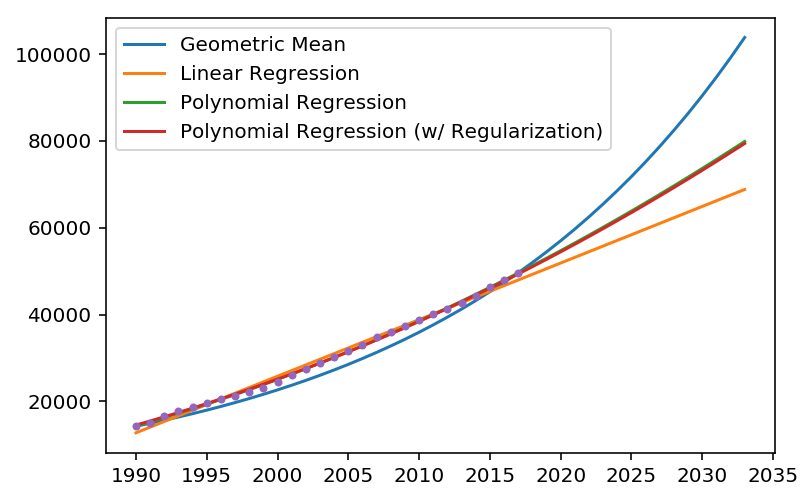

In [52]:
X_ = pd.date_range(str(historical_amts.index[0].year), 
                  str(YEAR_ENTERING_COLLEGE), freq='YS')
y1 = [int(cm(y)) for y in X_.year]
y2 = lm(X_.year)
y3 = pm(X_.year)
y4 = pmr.predict(X_.year.values.reshape(-1, 1))
plt.plot(X_, y1, label='Geometric Mean')
plt.plot(X_, y2, label='Linear Regression')  
plt.plot(X_, y3, label='Polynomial Regression')
plt.plot(X_, y4, label='Polynomial Regression (w/ Regularization)')
plt.plot(historical_amts.index.values, historical_amts.tuition.values, '.')
plt.legend()

print('Total cost of education (Compounding Model): ${:,}'.format(total_cost_of_education_cm))
print('Total cost of education (Linear Model)     : ${:,}'.format(total_cost_of_education_lm))
print('Total cost of education (Polynomial Model) : ${:,}'.format(total_cost_of_education_pm))
print('Total cost of education (Ridge Model)      : ${:,}'.format(total_cost_of_education_pmr))

## Smoothing Splines

In [158]:
from scipy.interpolate import UnivariateSpline

In [159]:
X = historical_amts.index.year
y = historical_amts['tuition']

In [160]:
sm = UnivariateSpline(X, y, k=2)

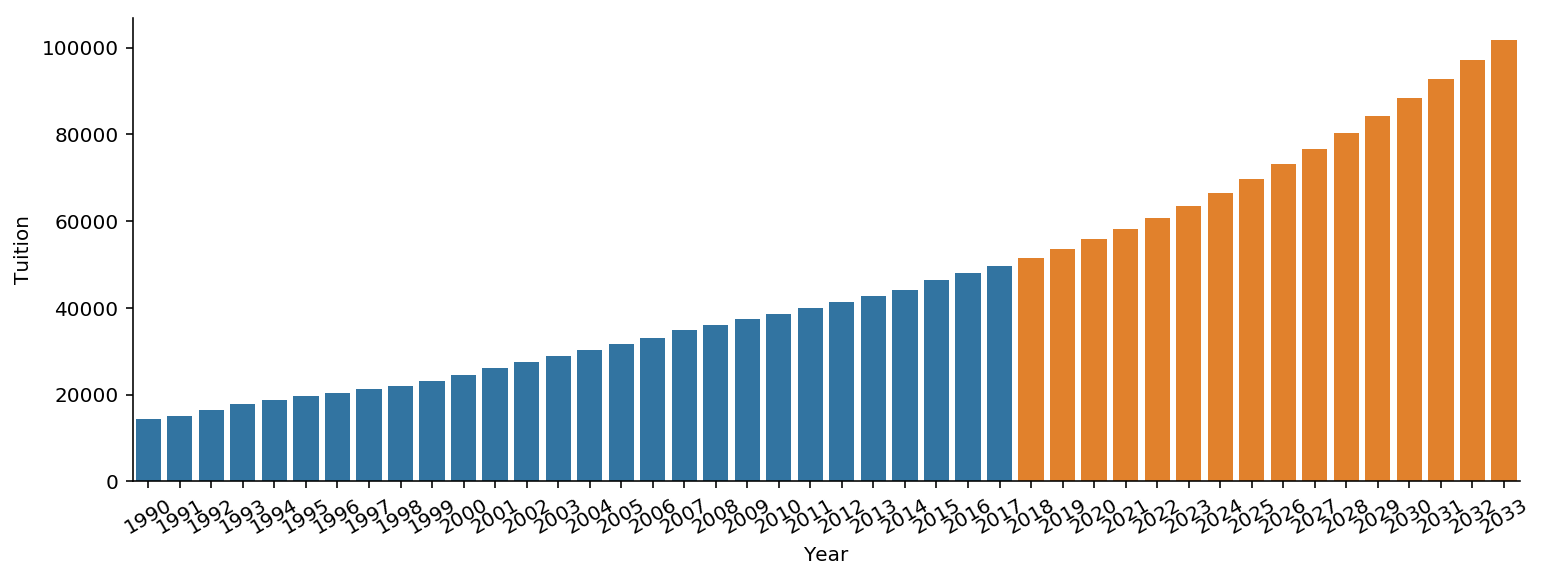

In [161]:
predicted_amts = predict(sm, 
                         historical_amts.index[-1].year + 1, 
                         YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

In [162]:
predicted_amt = int(sm(YEAR_ENTERING_COLLEGE))
print('First year cost: ${:,}'.format(predicted_amt))
total_cost_of_education_sm = calc_cost_of_college(sm, YEAR_ENTERING_COLLEGE)
print('Total cost of education: ${:,}'.format(total_cost_of_education_sm))

First year cost: $101,794


NameError: name 'calc_cost_of_college' is not defined

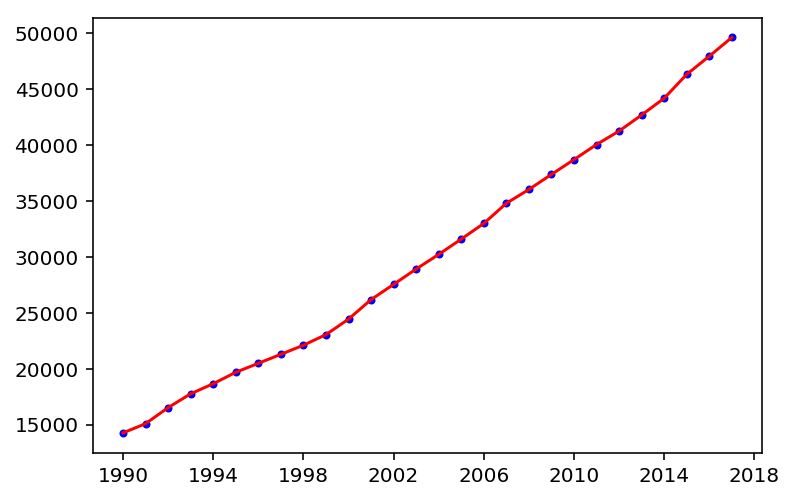

In [163]:
plot_fit(historical_amts, sm)

NameError: name 'X_' is not defined

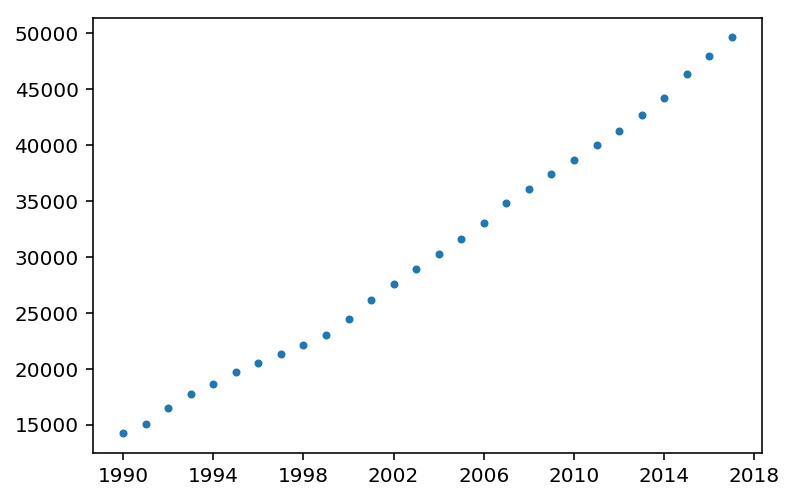

In [164]:
plt.plot(historical_amts.index.values, historical_amts.tuition.values, '.')
plt.plot(X_, sm(X_.year))

In [165]:
X_ = pd.date_range(str(historical_amts.index[0].year), 
                  str(YEAR_ENTERING_COLLEGE), freq='YS')
y1 = [int(cm(y)) for y in X_.year]
y2 = lm(X_.year)
y3 = pm(X_.year)
y4 = pmr.predict(X_.year.values.reshape(-1, 1))
y5 = sm(X_.year)
plt.plot(X_, y1, label='Geometric Mean')
plt.plot(X_, y2, label='Linear Regression')  
plt.plot(X_, y3, label='Polynomial Regression')
plt.plot(X_, y4, label='Polynomial Regression (w/ Regularization)')
plt.plot(X_, y5, label='Smoothing Spline')
plt.plot(historical_amts.index.values, historical_amts.tuition.values, '.')
plt.legend()

print('Total cost of education (Compounding Model)      : ${:,}'.format(total_cost_of_education_cm))
print('Total cost of education (Linear Model)           : ${:,}'.format(total_cost_of_education_lm))
print('Total cost of education (Polynomial Model)       : ${:,}'.format(total_cost_of_education_pm))
print('Total cost of education (Ridge Model)            : ${:,}'.format(total_cost_of_education_pmr))
print('Total cost of education (Smoothing Spline Model) : ${:,}'.format(total_cost_of_education_sm))

NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### What the F@$%?!?!

Oh man, this is not what I expected at all! Looking over the text, it would appear that polynomial regression would yield the worst possible answer due to the high ["leverage"][leverage] in the tails. However, we see here that smoothing splines give a much worse answer than a polynomial regression. Why is this?

[leverage]: https://en.wikipedia.org/wiki/Leverage_(statistics)

## Cubic Spline Regression

In [166]:
from scipy.interpolate import CubicSpline

In [167]:
X = historical_amts.index.year
y = historical_amts['tuition']

In [168]:
csm = CubicSpline(X, y)

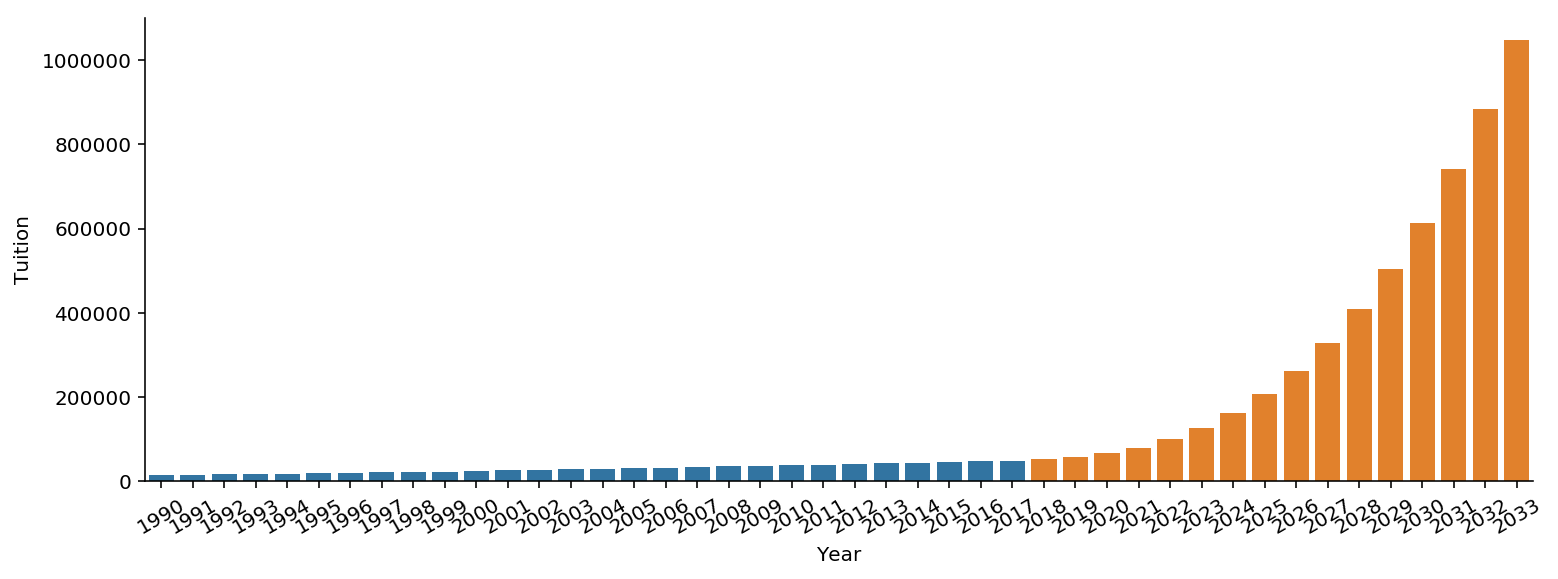

In [169]:
predicted_amts = predict(csm, 
                         historical_amts.index[-1].year + 1, 
                         YEAR_ENTERING_COLLEGE)
plot_predictions(historical_amts, predicted_amts)

In [170]:
predicted_amt = int(csm(YEAR_ENTERING_COLLEGE))
print('First year cost: ${:,}'.format(predicted_amt))
total_cost_of_education_csm = calc_cost_of_college(csm, YEAR_ENTERING_COLLEGE)
print('Total cost of education: ${:,}'.format(total_cost_of_education_csm))

First year cost: $1,047,873


NameError: name 'calc_cost_of_college' is not defined

## Local Regression

The following uses R's `loess` method to perform a local regression on the data. I then use the resultant model to extrapolate out the years that Ellie will be in college. The result looks a lot like the polynomial regression I ran above. 

> Note: It may be a good idea to just leave this section out completely since it appears that the prevailing wisdom is that local regression is for smoothing only, and consequently is useful for interpolation, but not extrapolation. This is further evidenced by the fact that you must "turn on" extrapolation when using the `loess` fuction; i.e., it's not on by default. On the other hand, since the prediction of this model so closely matches the polynomial models, it may be a good idea to keep this as further evidence for going with the polynomial model prediction. At the very least, it seems to strengthen the argument against a linear model.

In [171]:
%load_ext rpy2.ipython

The following code just moves the index (specifically the year value itself) into a column in the data frame since I don't know how to work with the index in R.

In [172]:
df = pd.DataFrame({'year': historical_amts.index.year, 'tuition': historical_amts.tuition})
df.reset_index(drop=True, inplace=True)

The main thing to notice below is that I am setting the `surface` parameter to `"direct"` in order to turn on the ability to use the model for extrapolation.

In [ ]:
%%R -i df -o college_costs -w 9 -h 7 -u in -r 220

lrm <- loess(tuition ~ year, df, control=loess.control(surface="direct"))
college_costs <- predict(lrm, data.frame(year = seq(2033, 2036, 1)))

In [1]:
predicted_amt = int(college_costs[0])
print('First year cost: ${:,}'.format(predicted_amt))
total_cost_of_education_lrm = int(sum(college_costs))
print('Total cost of education: ${:,}'.format(total_cost_of_education_lrm))

NameError: name 'college_costs' is not defined

## Average Total Cost of Education

The code below assumes that the right amount is actually somewhere between the compounding method and the fitted polynomial method, and it finds that value by averaging the different totals that each of these models produce.

In [ ]:
avg_total_cost_of_education = np.mean([total_cost_of_education_cm,
                                       total_cost_of_education_pm,
                                       total_cost_of_education_pmr,
                                       total_cost_of_education_sm,
                                       total_cost_of_education_lrm])
print('Average Total cost of education: ${:,}'.format(int(avg_total_cost_of_education)))

deposit_amt = calc_deposit_amount(avg_total_cost_of_education, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

## Model Comparison

The one thing I still need to do is to compare each of the models. In the following section, I take each model and compare the RMSE of each to figure out which one is the best.

## The CNBC Article

I finally figured out how the [CNBC team is coming up with their estimate][cnbc]. Basically, they are calculating the average tuition increase (geometric mean) over the last 18 years and using that estimate to extrapolate out the cost of attending Stanford for 4 years starting in the year 2036 (i.e., 18 years from now). The code below executes this strategy and comes up with the same amount.

[cnbc]: https://www.cnbc.com/2018/05/17/attending-harvard-will-cost-475000-in-2036-heres-how-much-other-schools-will-charge.html

In [ ]:
start = str(historical_amts.index[-1].year - 18)
_cm = train_compounding_model(historical_amts[start:])
_total_cost_of_education_cm = calc_cost_of_college(_cm, 2036)
print('Total cost of education (Compounding Model): ${:,}'.format(_total_cost_of_education_cm))

Using this approach, I can use the same compounding model, but with a 15 year window, instead of 18. Doing so, I get the following total cost and bi-weekly payment amounts.

In [ ]:
start = str(historical_amts.index[-1].year - 15)
_cm = train_compounding_model(historical_amts[start:])
_total_cost_of_education_cm = calc_cost_of_college(_cm, YEAR_ENTERING_COLLEGE)
print('Total cost of education (Compounding Model): ${:,}'.format(_total_cost_of_education_cm))
deposit_amt = calc_deposit_amount(_total_cost_of_education_cm, 
                                  YEARS_TO_SAVE, 
                                  NUM_PAY_PERIODS_PER_YEAR, 
                                  EXPECTED_ROI,
                                  8000)
print('Bi-weekly deposit amount: ${:,}'.format(deposit_amt))

## Conclusion

In short, looking at the predictions made using the geometric mean to find the average rate of increase (the most aggressive estimate), we will need to have saved up approximately **\$445k** by saving around **\$600 per paycheck**. The more conservative estimate has us saving up right around **\$283k** in total by saving roughly **\$380 per paycheck**. And, finally, the middle of the road quadratic model would have us save **\$332k** in total by stashing away **\$450 per paycheck**.

## Inflation

In [27]:
inflation = pd.read_csv('inflation.csv', index_col='year', parse_dates=['year'])
tuition = pd.read_csv('stanford.csv', index_col='year', parse_dates=['year'])

In [28]:
tuition = pd.DataFrame(tuition.tuition.pct_change() * 100)

When we pull out the inflation rate increase, we notice a distinct downward trend in the increase in tuition. So, it looks like Stanford is keeping up with inflation and then adding an increase on top of that, but one that is shrinking over time. So, a good way to model this (that's obviously vastly more complex) is to try to predict both the inflation rate into the future and the trend in this "premium" over that rate and then combine them into a final prediction. The latter can be modeled via regression analysis as we've been doing, but the for the former, we may be able to use [information on government bond yields to predict inflation rates][predicting_inflation].

https://www.investopedia.com/articles/economics/08/yield-curve.asp

[predicting_inflation]: https://blog.wealthfront.com/forecast-inflation/

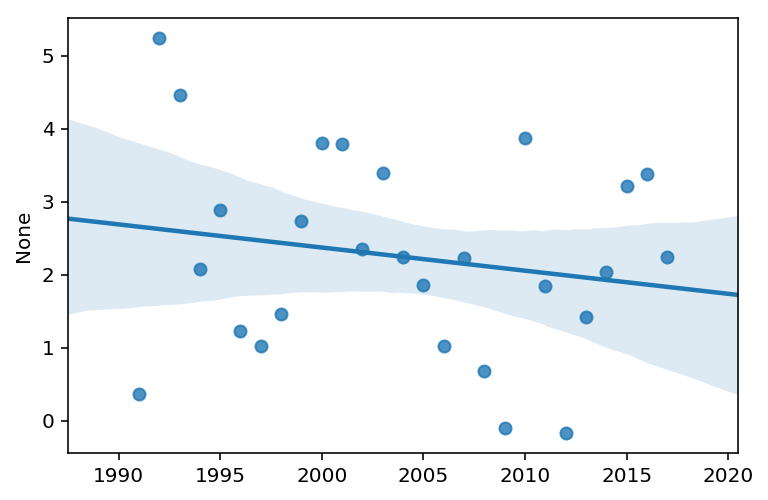

In [29]:
X = tuition.index.year.values
# I am shifting the inflation rates forward by 1 year, 
# so I can subtract the previous year's inflation rate 
# from the current year's tuition increase. In other words,
# I'm assuming that Stanford's tuition reacts to the prior
# year's increase. That said, regardless of whether I shift
# the rates or not, the trend is still the same.
y = tuition['tuition'] - inflation['inflation'].shift()
sns.regplot(X, y);

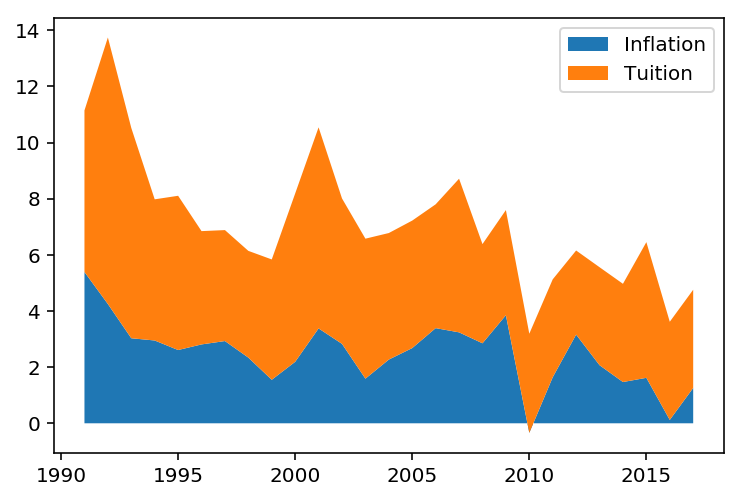

In [34]:
y1 = inflation['inflation']
y2 = tuition['tuition']
plt.stackplot(X, y1.shift(), y2, labels=['Inflation', 'Tuition'])
plt.legend();

Looking at the stacked plot above, it appears that Stanfor's tuition always lags the inflation rate by about a year. This is to be expected, since it's likely that the tuition increases are always reacting to changes in the economy rather than predicting it and making changes as the economy changes.

# Scikit-Learn Proposal

Currently sklearn has a very generic `TimeSeriesSplit` class that will create expanding training sets, up to some maximum size, and a test set of size `n_observations // n_splits`. This doesn't match what you see in the [literature][rhyndman] which usually uses a single data point that can be any number `n` steps ahead. I propose to add a few more tuning parameters that will allow the user to specify whether they want to perform traditional evaluation on a rolling origin forecast with `n` step-ahead forecasts and possibly also specify an expanding (default) vs. a sliding window for the training set. This could be done with the inclusion of the following parameters:

- `max_window_size=None` - if specified, the algorithm would 
- `step-ahead=None` - if `None`, test set is of size `n_observations // n_splits`, otherwise, the test set contains a single value `n` steps ahead of the end of the training set.

[rhyndman]: https://robjhyndman.com/hyndsight/tscv/

In [307]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
tscv = TimeSeriesSplit(n_splits=5, max_train_size=5)
for train, test in tscv.split(X):
    print(train, test)

[0] [1]
[0 1] [2]
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


In [308]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4],
              [1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
tscv = TimeSeriesSplit(n_splits=5, max_train_size=5)
for train, test in tscv.split(X):
    print(train, test)

[0 1] [2 3]
[0 1 2 3] [4 5]
[1 2 3 4 5] [6 7]
[3 4 5 6 7] [8 9]
[5 6 7 8 9] [10 11]
